<a href="https://colab.research.google.com/github/AshpreetKaur21/Deepfake-Image-detection/blob/main/Deepfake_Image_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download dagnelies/deepfake-faces

Dataset URL: https://www.kaggle.com/datasets/dagnelies/deepfake-faces
License(s): other
 96% 417M/433M [00:04<00:00, 106MB/s] 
100% 433M/433M [00:04<00:00, 94.0MB/s]


In [ ]:
! unzip deepfake-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: faces_224/yppwksjuui.jpg  
  inflating: faces_224/yppybofyww.jpg  
  inflating: faces_224/ypqjxdwawy.jpg  
  inflating: faces_224/ypqsxalhkw.jpg  
  inflating: faces_224/ypqxbbydxe.jpg  
  inflating: faces_224/ypqzrivawi.jpg  
  inflating: faces_224/yprdarrkit.jpg  
  inflating: faces_224/yprhthcacq.jpg  
  inflating: faces_224/yprmkhffdi.jpg  
  inflating: faces_224/yprnmqkhga.jpg  
  inflating: faces_224/yprqkgcoid.jpg  
  inflating: faces_224/yprsoygtjn.jpg  
  inflating: faces_224/yprxcbpmaj.jpg  
  inflating: faces_224/yprxtgidkk.jpg  
  inflating: faces_224/ypsbicsrsf.jpg  
  inflating: faces_224/ypsfvpanpn.jpg  
  inflating: faces_224/ypsgzbgbaz.jpg  
  inflating: faces_224/ypskfnxajx.jpg  
  inflating: faces_224/ypskxfumwo.jpg  
  inflating: faces_224/ypslvqfsrd.jpg  
  inflating: faces_224/ypsmruzzyt.jpg  
  inflating: faces_224/ypsqgodnrn.jpg  
  inflating: faces_224/ypsydrqqsl.jpg  
  inflating: faces_224/yptcha

In [ ]:
# System & General libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import time
from collections import defaultdict

# Image Processing & Computer Vision
import cv2

# Machine Learning & Deep Learning
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


# Data Visualization
import plotly.graph_objs as go
from plotly.offline import iplot
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_theme(style='whitegrid', palette='viridis', font_scale=1.2)

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
mp = defaultdict(lambda: "Not Present")
mp['/device:GPU:0'] = 'GPU T4 x2'
if tf.test.is_gpu_available():
    device = tf.test.gpu_device_name()
    print(f'✅ GPU is available: {mp[device]}')
else:
    print('⚠️ No GPU available. Using CPU.')
print(f'🔸 Tensorflow Version: {tf.__version__}')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


✅ GPU is available: GPU T4 x2
🔸 Tensorflow Version: 2.17.1


In [ ]:
def get_data():
    return pd.read_csv('/content/metadata.csv')

meta = get_data()
meta.head()

videoname  original_width  original_height label        original
0  aznyksihgl.mp4             129              129  FAKE  xnojggkrxt.mp4
1  gkwmalrvcj.mp4             129              129  FAKE  hqqmtxvbjj.mp4
2  lxnqzocgaq.mp4             223              217  FAKE  xjzkfqddyk.mp4
3  itsbtrrelv.mp4             186              186  FAKE  kqvepwqxfe.mp4
4  ddvgrczjno.mp4             155              155  FAKE  pluadmqqta.mp4

In [ ]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['count'] = df.count().values
    summary_df['unique'] = df.nunique().values
    summary_df['missing#'] = df.isna().sum()
    summary_df['missing%'] = df.isna().sum() / len(df)
    return summary_df
summary(meta).style.background_gradient('Purples')

In [ ]:
print('Fake Images:', len(meta[meta.label=='FAKE']))
print('Real Images:', len(meta[meta.label=='REAL']))

Fake Images: 79341
Real Images: 16293


In [ ]:
real_df = meta[meta['label'] == 'REAL']
fake_df = meta[meta['label'] == 'FAKE']
sample_size = 16000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

In [ ]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 8000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

In [ ]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])

In [ ]:
Train_set.shape,Val_set.shape,Test_set.shape

((8960, 5), (3840, 5), (3200, 5))

In [ ]:
def plot_class_counts(train_set, val_set, test_set):
    sets = ['Train Set', 'Validation Set', 'Test Set']
    colors = ['#52A666', '#C15B4E']

    y = {
        'REAL': [np.sum(train_set == 'REAL'), np.sum(val_set == 'REAL'), np.sum(test_set == 'REAL')],
        'FAKE': [np.sum(train_set == 'FAKE'), np.sum(val_set == 'FAKE'), np.sum(test_set == 'FAKE')]
    }

    trace0 = go.Bar(x=sets, y=y['REAL'], name='REAL', marker={'color': colors[0]}, opacity=0.7)
    trace1 = go.Bar(x=sets, y=y['FAKE'], name='FAKE', marker={'color': colors[1]}, opacity=0.7)

    data = [trace0, trace1]
    layout = go.Layout(title='Count of Classes in each set:', xaxis={'title': 'Set'}, yaxis={'title': 'Count'})

    fig = go.Figure(data, layout)
    iplot(fig)

plot_class_counts(np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label']))

In [ ]:
plt.figure(figsize=(15,15), dpi=300)
for idx,i in enumerate(Train_set.index[75:100]):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = cv2.imread('/content/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg')
    #print(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    #/content/faces_224/aaagqkcdis.jpg

    plt.xlabel('FAKE Image' if Train_set.loc[i,'label']=='FAKE' else 'REAL Image')

plt.tight_layout()
plt.show()

In [ ]:
# Function for getting image paths and corresponding labels from set
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('/content/faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)

    return np.array(images),np.array(labels)

In [ ]:
X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)

In [ ]:
from functools import partial

tf.random.set_seed(42)
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 224, 224, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │      51,380,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,619,585 (196.91 MB)

 Trainable params: 51,619,585 (196.91 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=5,batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 86s 424ms/step - accuracy: 0.5030 - loss: 304.8701 - val_accuracy: 0.5117 - val_loss: 0.6937
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 102s 309ms/step - accuracy: 0.4865 - loss: 0.6960 - val_accuracy: 0.4909 - val_loss: 0.6936
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 304ms/step - accuracy: 0.5093 - loss: 0.6931 - val_accuracy: 0.4885 - val_loss: 0.6947
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 305ms/step - accuracy: 0.5000 - loss: 0.6991 - val_accuracy: 0.4945 - val_loss: 0.6948
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 307ms/step - accuracy: 0.5073 - loss: 0.6927 - val_accuracy: 0.4935 - val_loss: 0.6949


In [ ]:
score = model.evaluate(X_test, y_test)

100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.4783 - loss: 0.6941


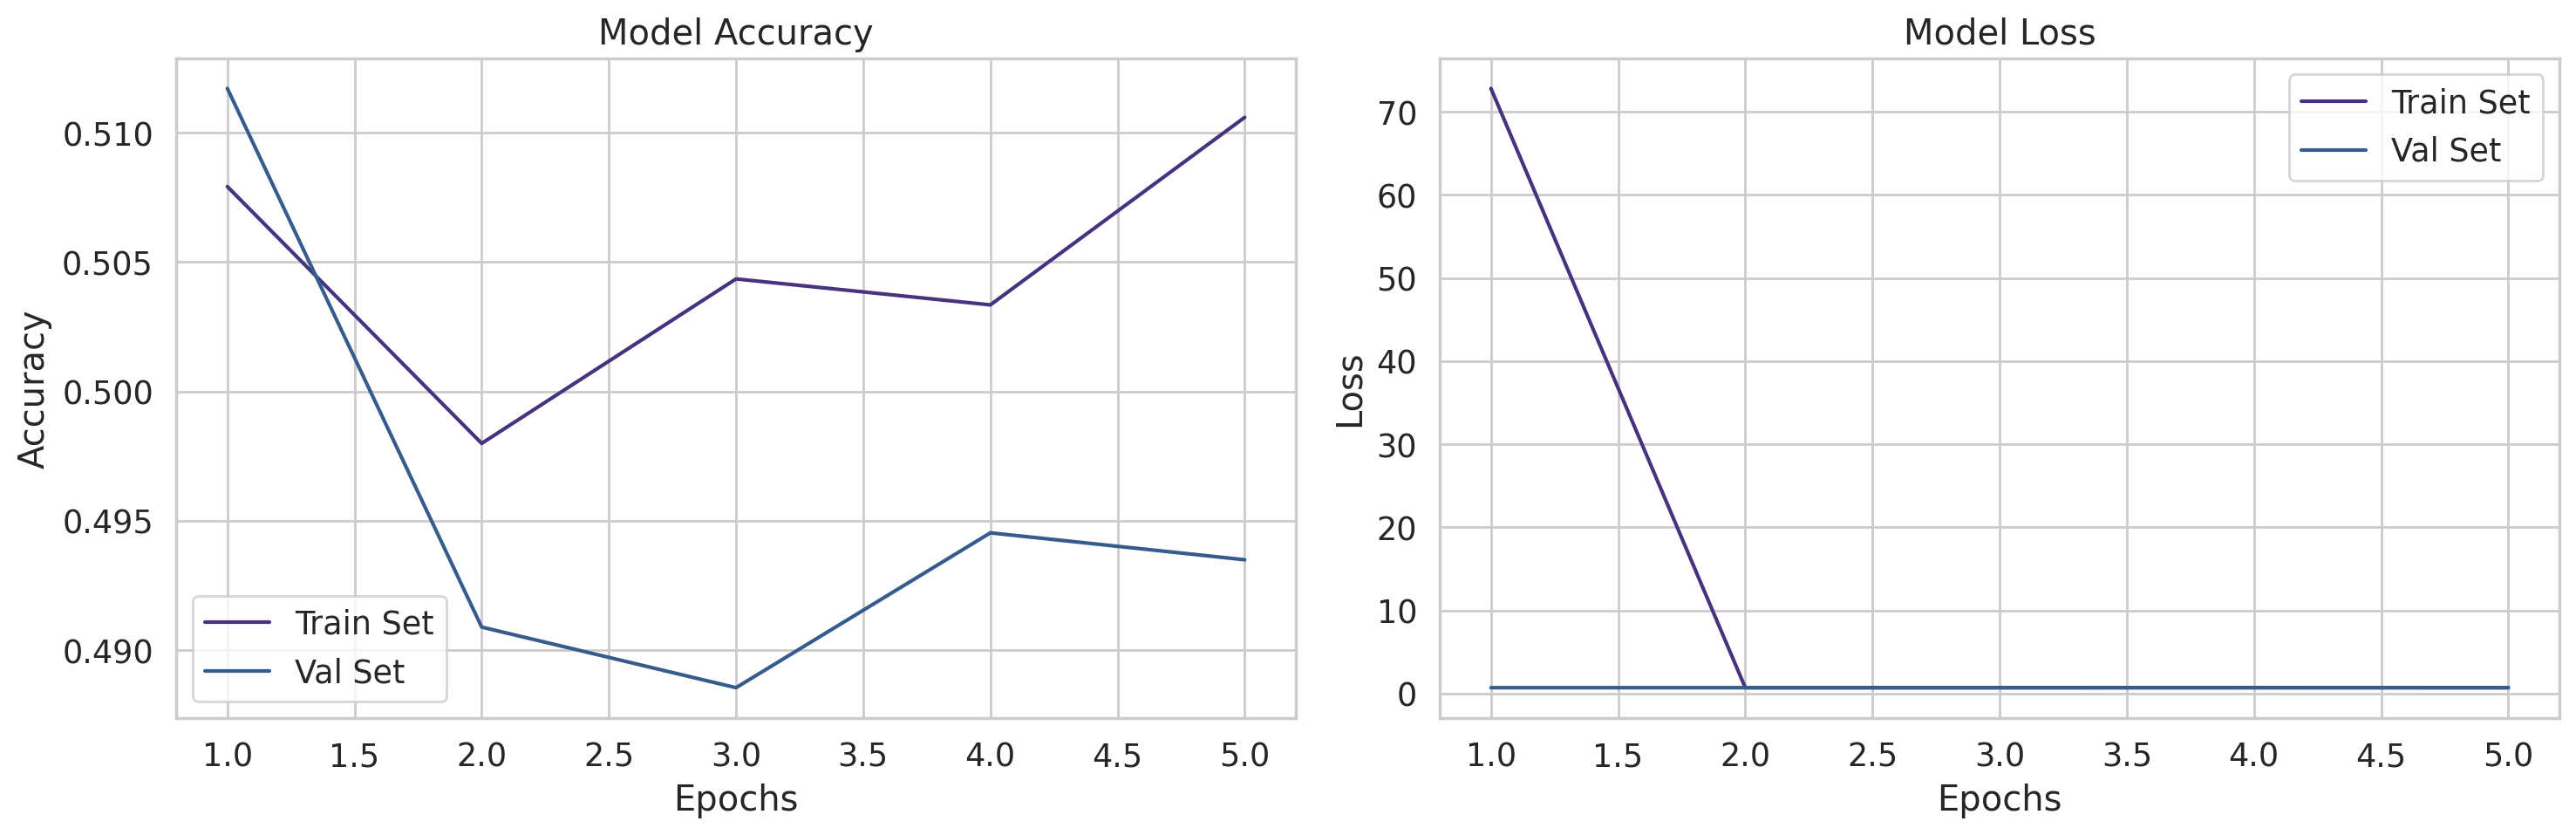

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [ ]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

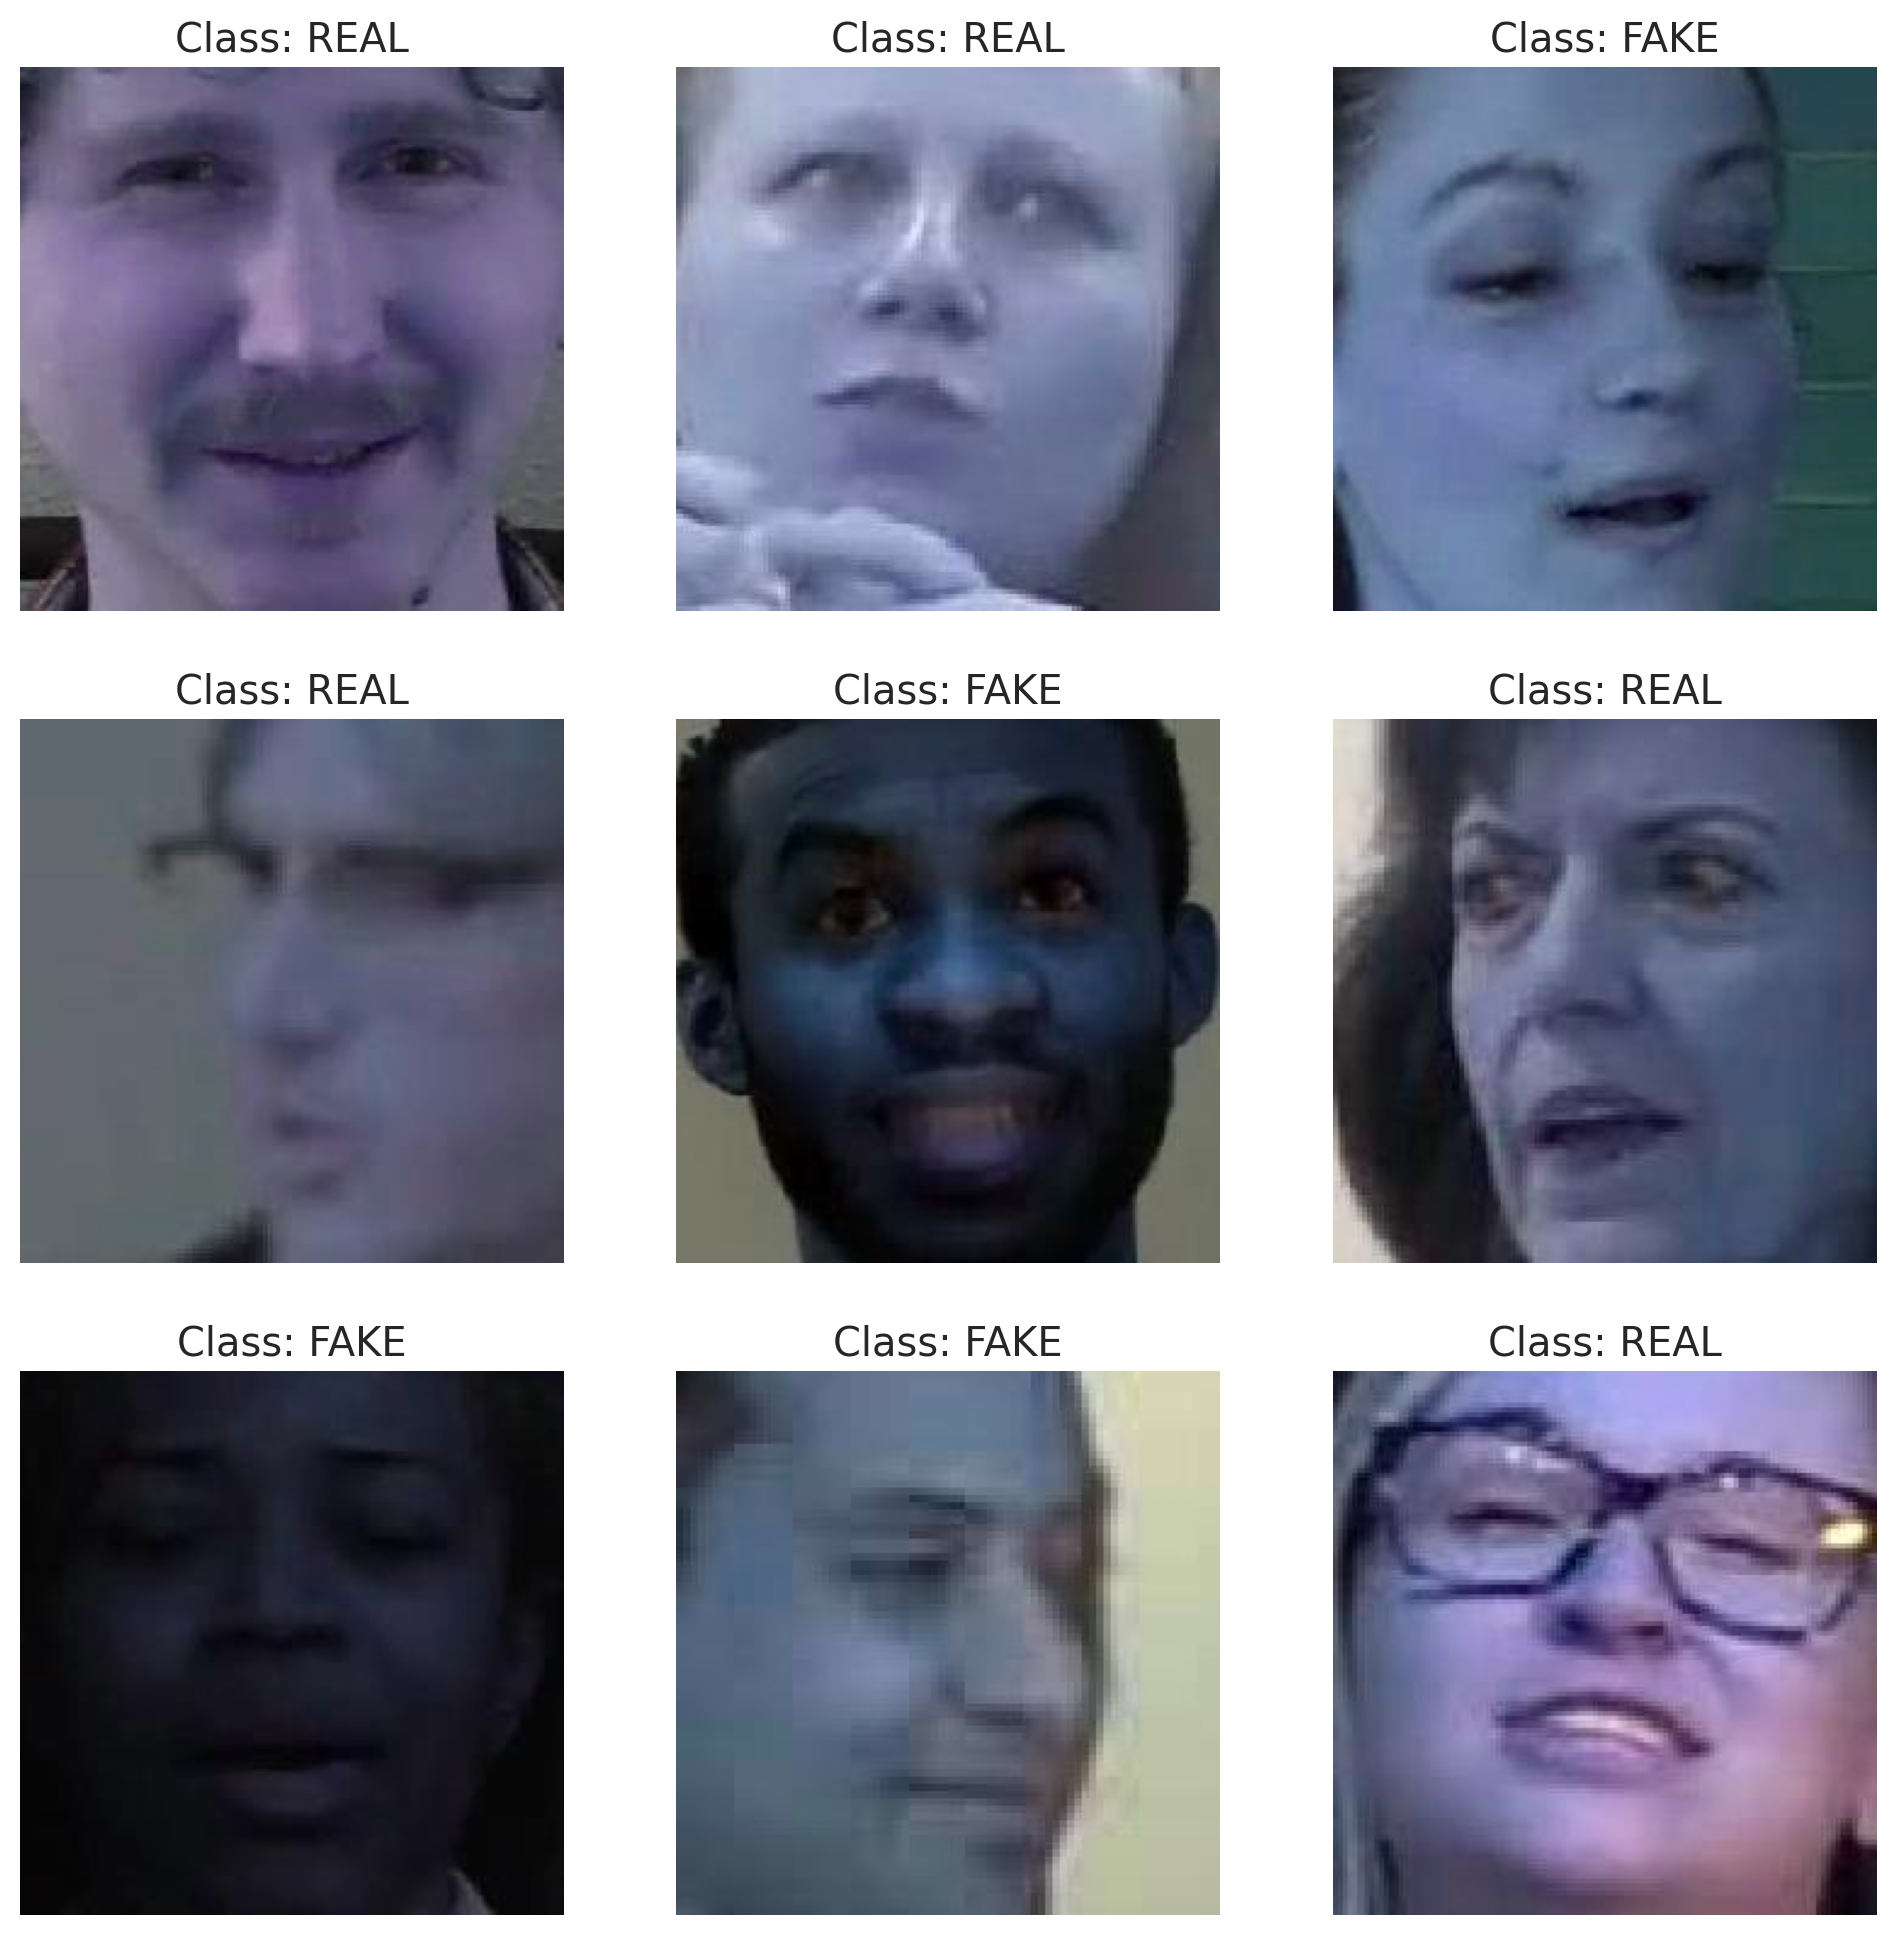

In [ ]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

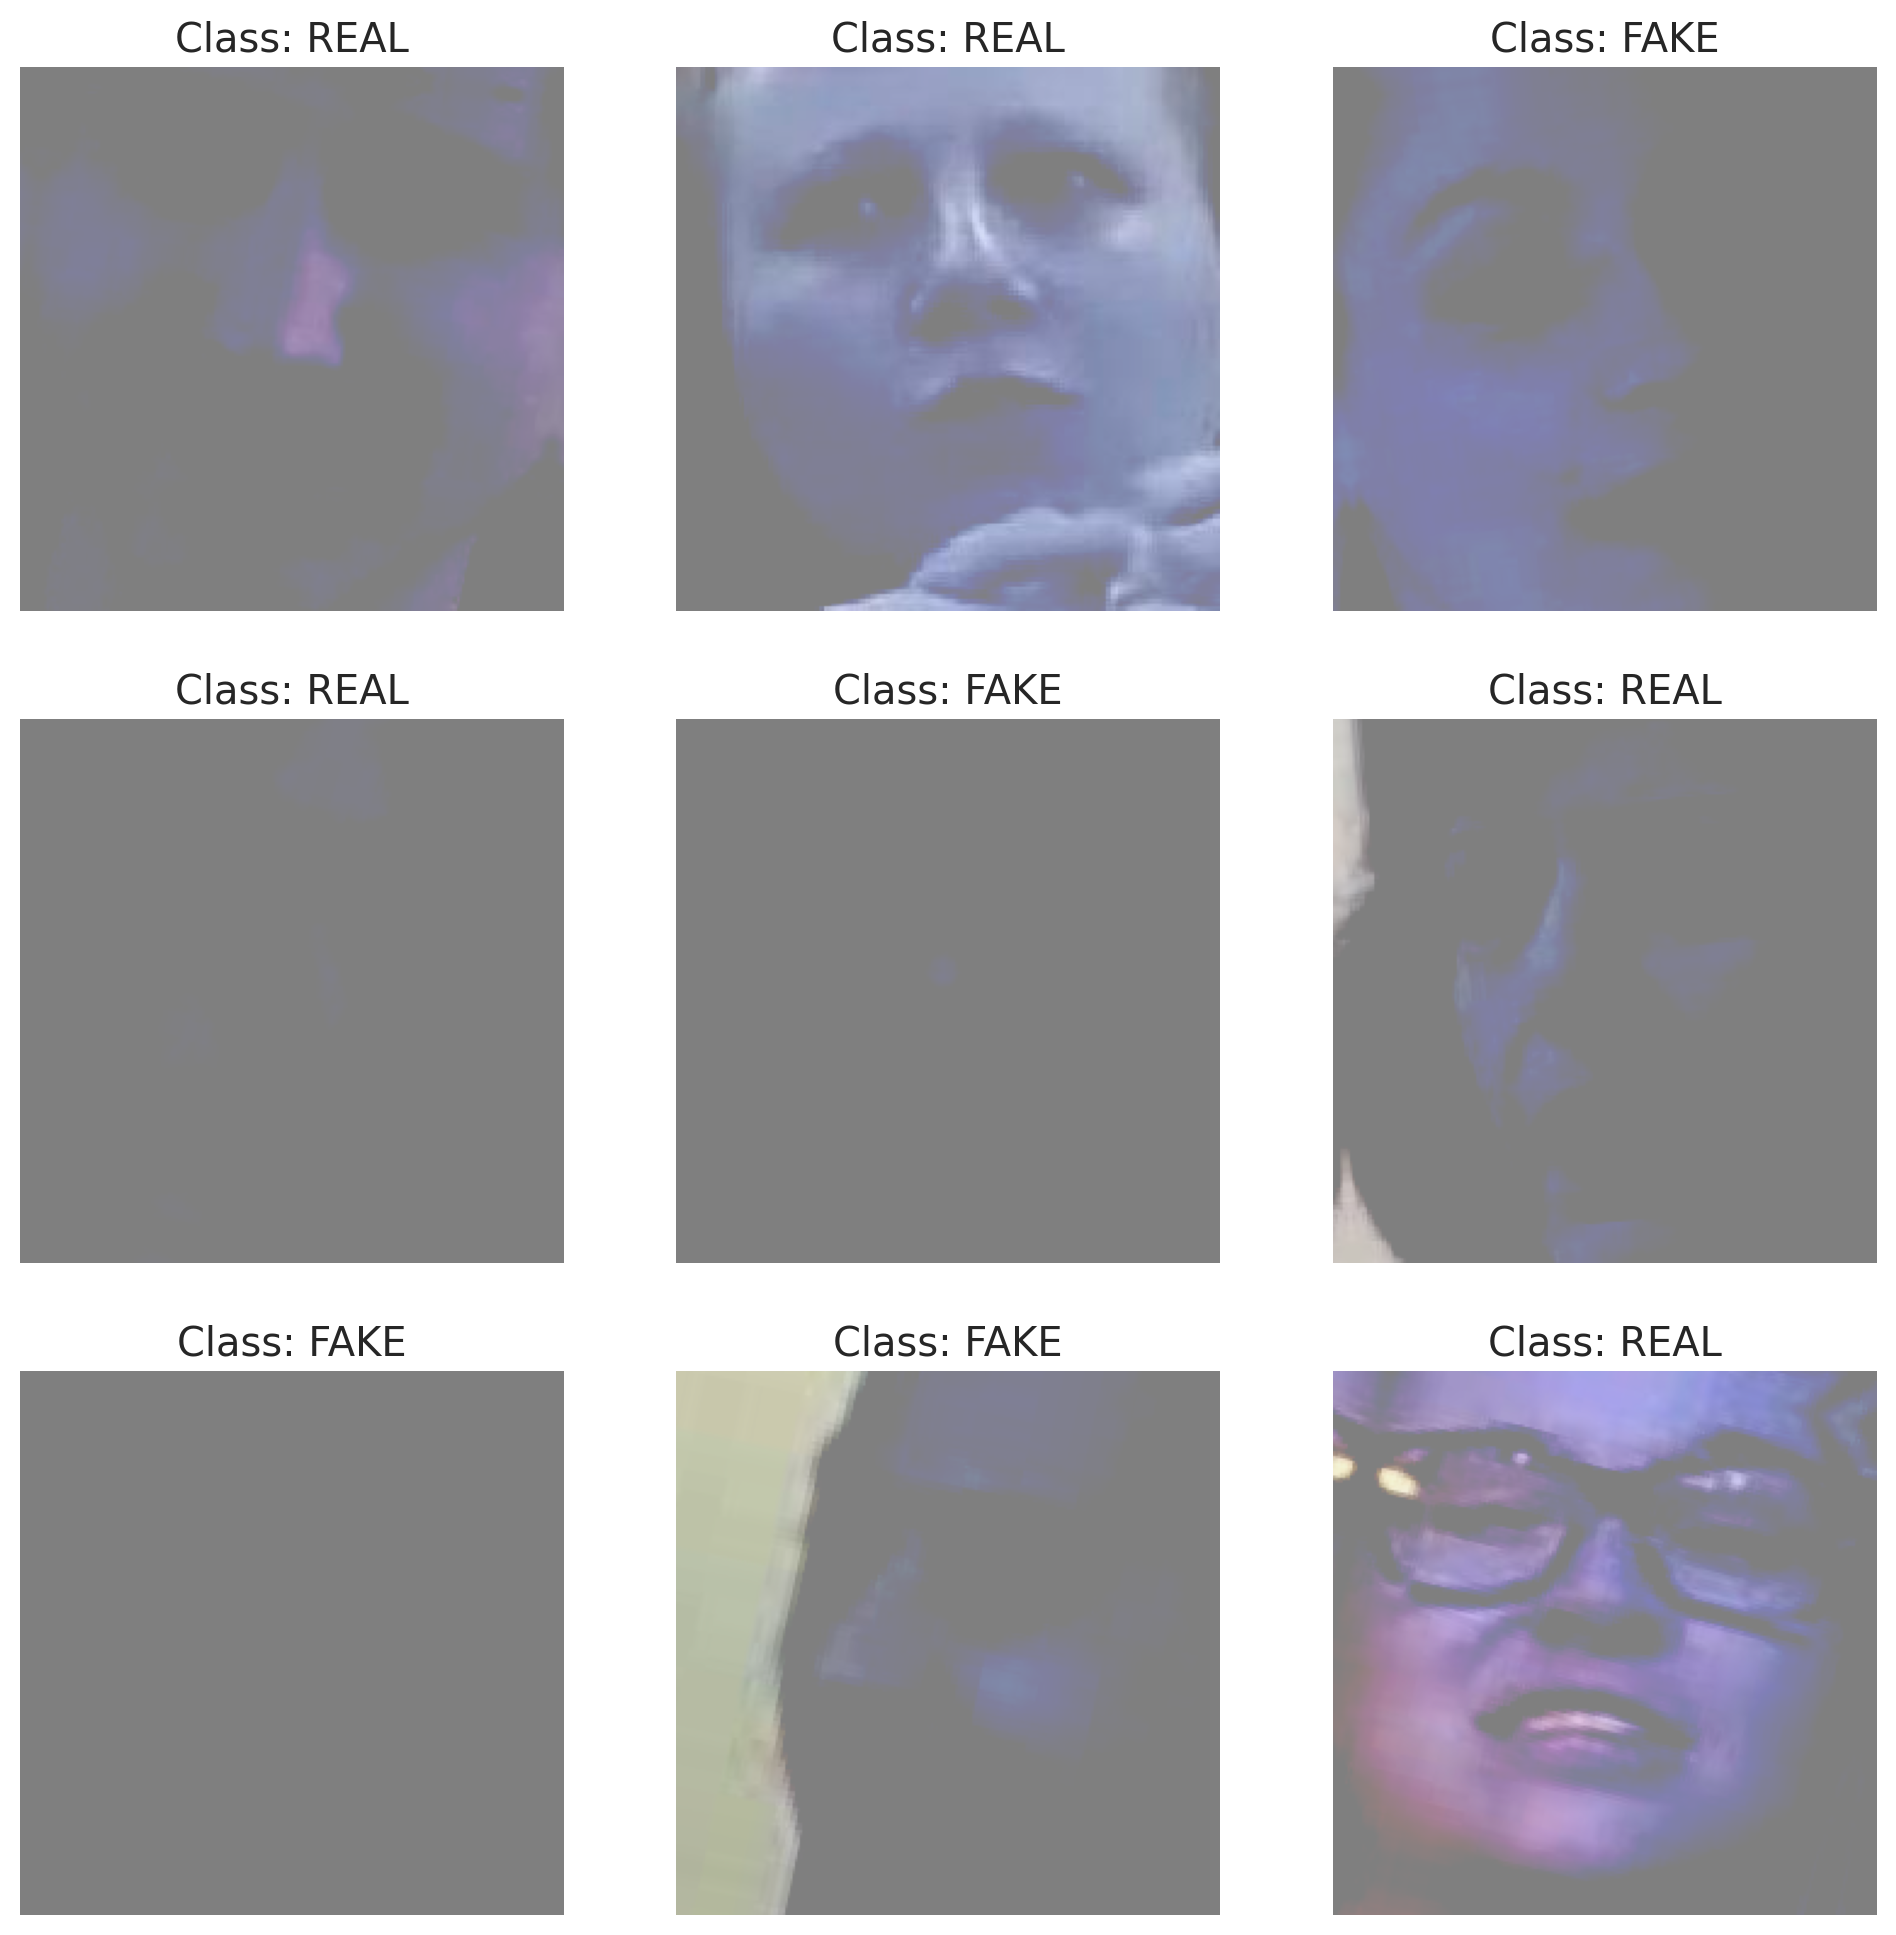

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 70s 195ms/step - accuracy: 0.5694 - loss: 0.9040 - val_accuracy: 0.5628 - val_loss: 1.4715
Epoch 2/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 71s 190ms/step - accuracy: 0.5985 - loss: 1.0499 - val_accuracy: 0.6398 - val_loss: 0.7577
Epoch 3/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 75s 164ms/step - accuracy: 0.6266 - loss: 0.9069 - val_accuracy: 0.6167 - val_loss: 0.9281


In [ ]:
model.evaluate(test_set)

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.6325 - loss: 0.8985


[0.9340218305587769, 0.6193749904632568]

In [ ]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_1          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 106s 305ms/step - accuracy: 0.6216 - loss: 0.6747 - val_accuracy: 0.7365 - val_loss: 0.5358
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 136s 322ms/step - accuracy: 0.8420 - loss: 0.3554 - val_accuracy: 0.7529 - val_loss: 0.6697
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 135s 299ms/step - accuracy: 0.9296 - loss: 0.1857 - val_accuracy: 0.7831 - val_loss: 0.6493
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 149s 324ms/step - accuracy: 0.9553 - loss: 0.1200 - val_accuracy: 0.7844 - val_loss: 0.7164
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 142s 324ms/step - accuracy: 0.9671 - loss: 0.0848 - val_accuracy: 0.8000 - val_loss: 0.6552
Epoch 6/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 93s 331ms/step - accuracy: 0.9797 - loss: 0.0578 - val_accuracy: 0.7872 - val_loss: 0.7173
Epoch 7/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 143s 334ms/step - accuracy: 0.9839 - loss: 0.0450 - val_accuracy: 0.7930 - val_loss: 0.8551
Epoch 8/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 135s 310ms/step - accuracy: 0.9875 - 

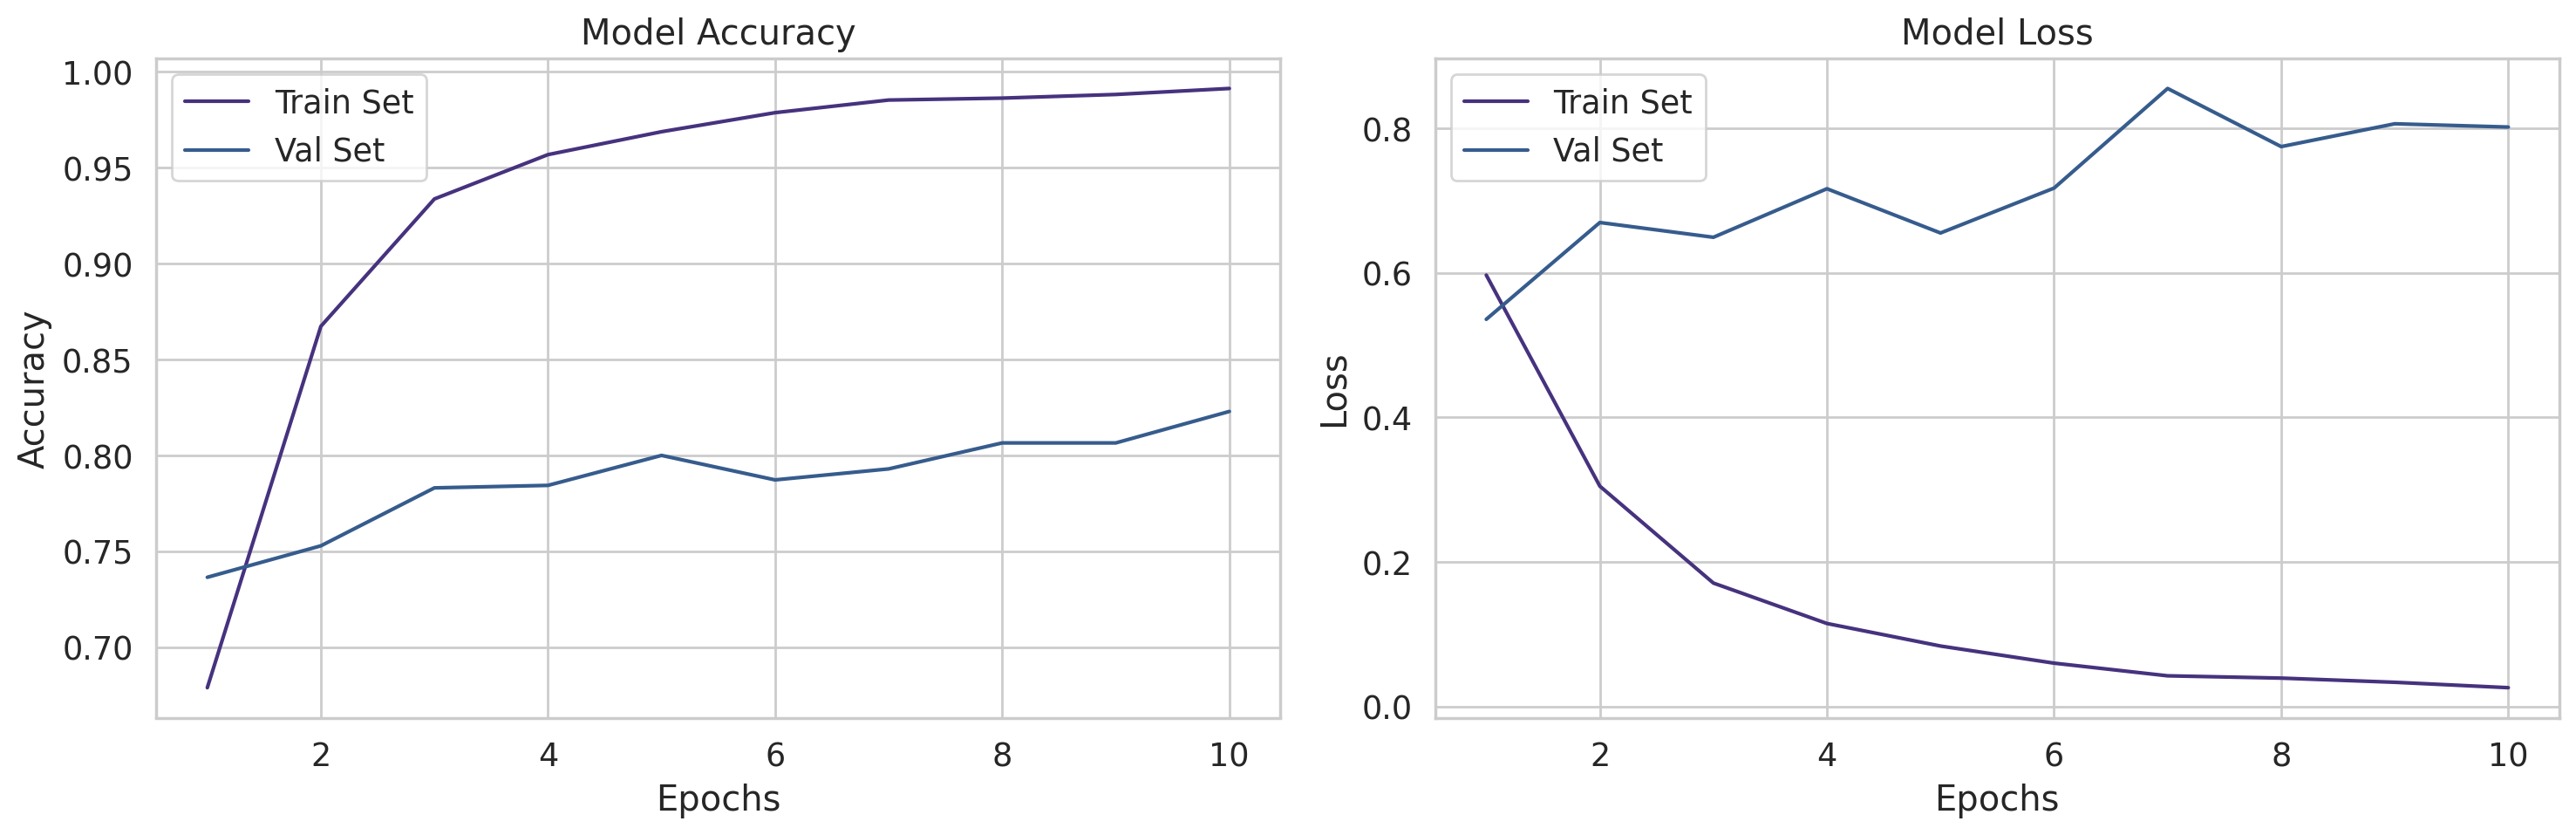

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
model.evaluate(test_set)

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.8193 - loss: 0.7811


[0.737346351146698, 0.8243749737739563]

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
tf.saved_model.save(model, 'saved_model/xception_deepfake_image.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model.save("/content/drive/MyDrive/xception_deepfake_image.h5")

In [ ]:
import torch # this is not necessary
# model_save_name = 'deepfake_model' #this is also not necessary
# path = F"/content/gdrive/My Drive/{model_save_name}" #this is also not necessary
# torch.save(model.state_dict(), path) #this is causing the error as you are using a pytorch method to save a tensorflow model.
model.save("/content/gdrive/MyDrive/deepfake_model.h5") # save the model as a .h5 file using tensorflow save method

In [ ]:
# Save the entire model as a `.keras` zip archive.
model.save('my_model.keras')

In [ ]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/xception_deepfake_image.h5

xception_deepfake_image.h5
assets	fingerprint.pb	saved_model.pb	variables


In [ ]:
model.save('xception_deepfake_image.h5')

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6feba21c8269fc523d3b170777bf4c9b4f5265f0f6cb41a0e5285e4b98faf3b6
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()